In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
import tensorflow as tf
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.autograd.variable import Variable

import math
import matplotlib.pyplot as plt
import numpy as np
import copy
from torchvision.utils import make_grid

from transformers import enable_full_determinism

device = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")
torch.manual_seed(1)


In [6]:
batch_size = 10

DATASET_SCALE = 0.1 # 10% of initial dataset for train, val and test
DATASET_SPLIT = [0.8, 0.2]

# Note to self: moved from /files/ to ./data for lab consistency (see lab 0)
temp_set = torchvision.datasets.MNIST('./data', train=True, download=True)
test_set = torchvision.datasets.MNIST('./data', train=False, download=True)

subsample_train_indices = torch.randperm( len(temp_set) )[:int(len(temp_set)*DATASET_SCALE)]
temp_set = DataLoader(test_set, sampler=SubsetRandomSampler(subsample_train_indices))

subsample_test_indices = torch.randperm( len(test_set) )[:int(len(test_set)*DATASET_SCALE)]
test_dataset = DataLoader(test_set, sampler=SubsetRandomSampler(subsample_test_indices))

train_dataset, val_dataset = random_split(temp_set, DATASET_SPLIT)

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
trainset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(1e-2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Tanh()
                    )

    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 256),
                    nn.LeakyReLU(1e-2),
                    #nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.LeakyReLU(1e-2),
                    nn.Sigmoid()
                    )

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc0(x)
        x = self.fc1(x)
        return x

In [8]:

generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

gen_optim = optim.Adam(generator.parameters(), lr=1e-4)
dis_optim = optim.Adam(discriminator.parameters(), lr=1e-4)

g_losses = []
d_losses = []
images = []




def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)
    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    error_real = criterion(prediction_real, torch.ones(n, 1).to(device))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = criterion(prediction_fake, (torch.zeros(n, 1)).to(device))
    
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    error = criterion(prediction, torch.ones(n,1).to(device))
    
    error.backward()
    optimizer.step()
    
    return error



In [9]:
num_epochs = 10
k = 1
min_loss = 10
if 1==0:
    criterion = nn.BCELoss()
else:
    criterion = nn.BCEWithLogitsLoss()
    
generator.train()
discriminator.train()


for epoch in range(num_epochs):
    gen_error = 0.0
    dis_error = 0.0
    for i, data in enumerate(train_loader):
        imgs, _ = data
        n = len(imgs)
        for j in range(k):
            fake_data = generator(Variable(torch.randn(n, 128)).to(device).detach())
            real_data = imgs.to(device)
            dis_error += (train_discriminator(dis_optim, real_data, fake_data)).cpu().detach().numpy().sum()
        fake_data = generator(torch.randn(n, 128).to(device))
        gen_error += (train_generator(gen_optim, fake_data)).cpu().detach().numpy().sum()


    
    gen_v_error = 0.0
    dis_v_error = 0.0
    for i, data in enumerate(val_loader):
        imgs, _ = data
        n = len(imgs)
        for j in range(k):
            fake_data = generator(Variable(torch.randn(n, 128)).to(device).detach())
            real_data = imgs.to(device)
            dis_v_error += (train_discriminator(dis_optim, real_data, fake_data)).cpu().detach().numpy().sum()
        fake_data = generator(torch.randn(n, 128).to(device))
        
        gen_v_error += (train_generator(gen_optim, fake_data)).cpu().detach().numpy().sum()
         

    g_losses.append(gen_error/i)
    d_losses.append(dis_error/i)
    
    d_v_losses.append(dis_v_error/i)
    g_v_losses.append(gen_v_error/i)
    print('Training:   Epoch {}: generator_loss: {:.8f} discriminator_loss: {:.8f}\r'.format(epoch, gen_error/i, dis_error/i))
    print('Validation: Epoch {}: generator_loss: {:.8f} discriminator_loss: {:.8f}\r'.format(epoch, gen_v_error/i, dis_error/i))
    validation_loss.append(epoch_validation_loss/len(val_loader))
    
    if ((math.sqrt(gen_v_error/i) + math.sqrt(dis_v_error/i)) < min_loss):
        torch.save(generator, 'best_generator_acc.pt')
        torch.save(discriminator, 'best_discriminator_acc.pt')
        min_loss = math.sqrt(gen_v_error/i)+math.sqrt(dis_v_error/i)



TypeError: 'DataLoader' object is not subscriptable

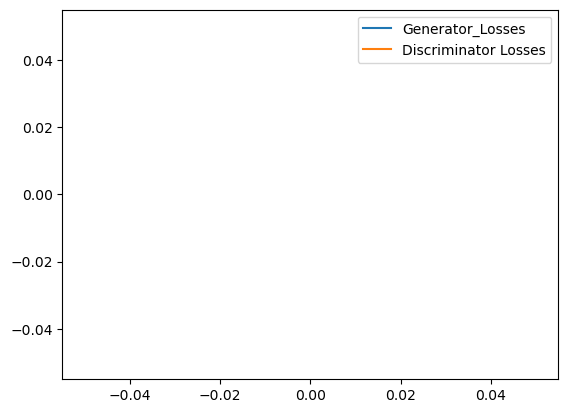

In [8]:
plt.plot(g_losses, label='Generator_Losses')
plt.plot(d_losses, label='Discriminator Losses')
plt.legend()
plt.savefig('loss.png')

In [94]:
generator_state = torch.load('best_generator_acc.pt')
discriminator_state = torch.load('best_discriminator_acc.pt')


print(f'Model states contains this data: {model.keys()}')

gan_type = model["gan_type"]  # 
print(f'Using {gan_type} GAN!')

generator = Generator().to(device)
generator.load_state_dict(generator_state["state_dict"], strict=True)
generator.eval() 

discriminator = Discriminator().to(device)
discriminator.load_state_dict(discriminator_state["state_dict"], strict=True)
discriminator.eval() 
    
generated_imgs_path = os.path.join(os.getcwd()+"images/", 'generated_imagery')  
os.makedirs(generated_imgs_path, exist_ok=True)

#
# This is where the magic happens!
#

print('Generating new MNIST-like images!')
generated_img = generate_from_random_latent_vector(generator)
save_and_maybe_display_image(generated_imgs_path, generated_img, should_display=True)

FileNotFoundError: [Errno 2] No such file or directory: 'best_generator_acc.pt'